In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import nltk
import re
import os

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download NLTK data
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/princess/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/princess/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/princess/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

Load the Dataset

In [4]:
data_path = 'video_features.csv'
df = pd.read_csv(data_path)

print("Dataset Loaded Successfully!")
print(df.head())
print("\nDataset Information:")
print(df.info())
print("\nMissing Values:")
print(df.isnull().sum())


Dataset Loaded Successfully!
  filename  duration_seconds   fps  width  height  num_frames  file_size_MB  \
0  140.mp4        171.390667  25.0   1280     720        4284     11.208204   
1  197.mp4        188.158667  25.0   1280     720        4703     31.291876   
2   68.mp4         10.007800  25.0    720     720         250      0.139423   
3  141.mp4        156.862667  25.0   1280     720        3921     13.209558   
4  155.mp4         68.880000  25.0   1280     720        1722      8.201943   

  codec  has_audio  audio_fps  audio_channels                      title  \
0  h264       True    48000.0               2     学生采访👩‍🎓👨‍🎓｜金融学(金融科技)硕士   
1  h264       True    48000.0               2           香港大学111周年庆祝活动回顾🎊   
2  h264       True    44100.0               2          港大经管硕士祝大家中秋节快乐🎑🌕🐰   
3  h264       True    48000.0               2           学生采访👩‍🎓👨‍🎓｜金融学硕士   
4  h264       True    48000.0               2  港大经管硕士｜Orientation 2023🥳📚   

  publish_time  likes  
0   10/19/2023 

Data Pre-Processing

In [5]:
numerical_cols = ['duration_seconds', 'fps', 'width', 'height', 'num_frames',
                  'file_size_MB', 'audio_fps', 'audio_channels']
df[numerical_cols] = df[numerical_cols].fillna(df[numerical_cols].median())

# Fill categorical columns with mode
categorical_cols = ['codec', 'has_audio']
df[categorical_cols] = df[categorical_cols].fillna(df[categorical_cols].mode().iloc[0])

# Fill 'title' and 'publish_time'
df['title'] = df['title'].fillna('No Title')
df['publish_time'] = pd.to_datetime(df['publish_time'], errors='coerce')
df['publish_time'] = df['publish_time'].fillna(pd.Timestamp('2000-01-01'))

print("\nMissing Values After Imputation:")
print(df.isnull().sum())



Missing Values After Imputation:
filename            0
duration_seconds    0
fps                 0
width               0
height              0
num_frames          0
file_size_MB        0
codec               0
has_audio           0
audio_fps           0
audio_channels      0
title               0
publish_time        0
likes               0
dtype: int64


In [6]:
# 'has_audio' is boolean; convert to integer
df['has_audio'] = df['has_audio'].astype(int)

# Label Encode 'codec'
le_codec = LabelEncoder()
df['codec_encoded'] = le_codec.fit_transform(df['codec'])

# Drop original 'codec' column
df = df.drop('codec', axis=1)

# Ensure 'publish_time' is in datetime format
df['publish_time'] = pd.to_datetime(df['publish_time'], format='%m/%d/%Y')

# Extract date features
df['publish_year'] = df['publish_time'].dt.year
df['publish_month'] = df['publish_time'].dt.month
df['publish_day'] = df['publish_time'].dt.day
df['publish_dayofweek'] = df['publish_time'].dt.dayofweek
df['publish_hour'] = 12  # Default value as time is not provided

# Drop original 'publish_time' column
df = df.drop('publish_time', axis=1)

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['title_clean'] = df['title'].apply(clean_text)

# Remove stopwords and lemmatize
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

df['title_processed'] = df['title_clean'].apply(preprocess_text)

# TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=100)
tfidf_matrix = tfidf.fit_transform(df['title_processed'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out())

# Combine TF-IDF features with original DataFrame
df = pd.concat([df, tfidf_df], axis=1)

# Drop text-related columns
df = df.drop(['filename', 'title', 'title_clean', 'title_processed'], axis=1)

print("\nDataFrame After Text Processing:")
print(df.head())

numerical_features = ['duration_seconds', 'fps', 'width', 'height', 'num_frames',
                      'file_size_MB', 'audio_fps', 'audio_channels',
                      'publish_year', 'publish_month', 'publish_day',
                      'publish_dayofweek', 'publish_hour']

scaler = StandardScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])

print("\nScaled Numerical Features:")
print(df[numerical_features].head())


DataFrame After Text Processing:
   duration_seconds   fps  width  height  num_frames  file_size_MB  has_audio  \
0        171.390667  25.0   1280     720        4284     11.208204          1   
1        188.158667  25.0   1280     720        4703     31.291876          1   
2         10.007800  25.0    720     720         250      0.139423          1   
3        156.862667  25.0   1280     720        3921     13.209558          1   
4         68.880000  25.0   1280     720        1722      8.201943          1   

   audio_fps  audio_channels  likes  ...  mktg  msc  nyushnyu  orientation  \
0    48000.0               2     24  ...   0.0  0.0       0.0          0.0   
1    48000.0               2     12  ...   0.0  0.0       0.0          0.0   
2    44100.0               2     17  ...   0.0  0.0       0.0          0.0   
3    48000.0               2     17  ...   0.0  0.0       0.0          0.0   
4    48000.0               2     32  ...   0.0  0.0       0.0          1.0   

   program

Feature Selection

In [7]:

X = df.drop(['likes'], axis=1)
y = df['likes']

print("\nFeatures and Target Defined:")
print("X shape:", X.shape)
print("y shape:", y.shape)


Features and Target Defined:
X shape: (41, 33)
y shape: (41,)


Train/Test Splitting

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=42
)

print("\nData Split into Training and Testing Sets:")
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)



Data Split into Training and Testing Sets:
X_train shape: (20, 33)
X_test shape: (21, 33)
y_train shape: (20,)
y_test shape: (21,)


Model Training

In [9]:
xgb_reg = XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1
)
xgb_reg.fit(X_train, y_train)

print("\nInitial XGBoost Model Trained Successfully!")



Initial XGBoost Model Trained Successfully!


Hyperparameter Tuning

In [10]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

grid_search = GridSearchCV(
    estimator=xgb_reg,
    param_grid=param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1
)

print("\nStarting Grid Search for Hyperparameter Tuning...")
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("\nBest Hyperparameters Found:")
print(best_params)


Starting Grid Search for Hyperparameter Tuning...
Fitting 3 folds for each of 243 candidates, totalling 729 fits

Best Hyperparameters Found:
{'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 100, 'subsample': 0.8}


Model Evaluation

In [11]:
best_xgb = grid_search.best_estimator_
y_pred = best_xgb.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("\nModel Performance on Test Set:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.2f}")



Model Performance on Test Set:
Mean Squared Error (MSE): 1209.29
Root Mean Squared Error (RMSE): 34.77
R² Score: -0.06


Feature Importances

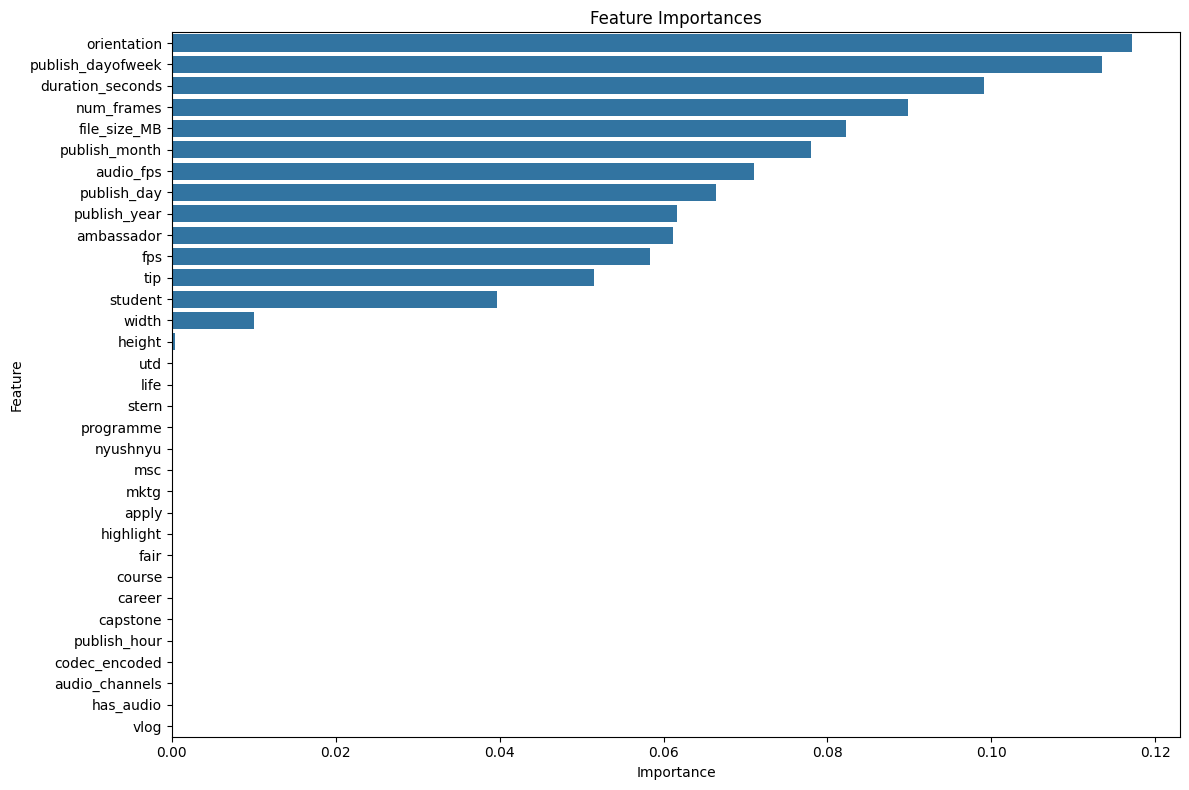

In [12]:
importances = best_xgb.feature_importances_
feature_names = X.columns

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importances')
plt.tight_layout()
plt.show()


Save Model

In [13]:
# Create the 'models' folder if it doesn't exist
os.makedirs('models', exist_ok=True)
model_folder = 'models/'

# Save the XGB model
model_filename = os.path.join(model_folder, 'video_feature_model.pkl')
joblib.dump(best_xgb, model_filename)
print(f"\nModel saved to {model_filename}")

# Save the scaler
scaler_filename = os.path.join(model_folder, 'scaler.pkl')
joblib.dump(scaler, scaler_filename)
print(f"Scaler saved to {scaler_filename}")

# Save the TF-IDF vectorizer
tfidf_filename = os.path.join(model_folder, 'tfidf_vectorizer.pkl')
joblib.dump(tfidf, tfidf_filename)
print(f"TF-IDF Vectorizer saved to {tfidf_filename}")

# Save the Label Encoder
label_encoder_filename = os.path.join(model_folder, 'label_encoder_codec.pkl')
joblib.dump(le_codec, label_encoder_filename)
print(f"Label Encoder saved to {label_encoder_filename}")

# Save the feature names
feature_names_filename = os.path.join(model_folder, 'feature_names.pkl')
joblib.dump(feature_names.tolist(), feature_names_filename)
print(f"Feature names saved to {feature_names_filename}")


Model saved to models/video_feature_model.pkl
Scaler saved to models/scaler.pkl
TF-IDF Vectorizer saved to models/tfidf_vectorizer.pkl
Label Encoder saved to models/label_encoder_codec.pkl
Feature names saved to models/feature_names.pkl


Prediction Function

In [16]:
import joblib
import pandas as pd
import numpy as np
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download NLTK data if not already downloaded
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Define the folder path where models are stored
model_folder = 'models/'

# Load preprocessing objects and model
model = joblib.load(f'{model_folder}video_feature_model.pkl')
scaler = joblib.load(f'{model_folder}scaler.pkl')
tfidf_vectorizer = joblib.load(f'{model_folder}tfidf_vectorizer.pkl')
le_codec = joblib.load(f'{model_folder}label_encoder_codec.pkl')
feature_names = joblib.load(f'{model_folder}feature_names.pkl')


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/princess/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/princess/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/princess/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [17]:
def predict_likes(model, scaler, tfidf_vectorizer, le_codec, feature_names,
                 duration_seconds, fps, width, height, num_frames, file_size_MB,
                 audio_fps, audio_channels, publish_time,
                 codec, has_audio, title):
    """
    Predict the number of likes for a video based on its features.

    Parameters:
    - model: Trained regression model.
    - scaler: Fitted StandardScaler object.
    - tfidf_vectorizer: Fitted TfidfVectorizer object.
    - le_codec: Fitted LabelEncoder for 'codec_encoded'.
    - feature_names: List of feature names in the order used during training.
    - duration_seconds (float)
    - fps (float)
    - width (int)
    - height (int)
    - num_frames (int)
    - file_size_MB (float)
    - audio_fps (float)
    - audio_channels (int)
    - publish_time (str): Date in 'mm/dd/yyyy' format.
    - codec (str): Codec used (e.g., 'h264').
    - has_audio (int): 1 if has audio, 0 otherwise.
    - title (str): Title of the video.

    Returns:
    - predicted_likes (float): Predicted number of likes.
    """
    # Handle publish_time
    try:
        publish_datetime = pd.to_datetime(publish_time, format='%m/%d/%Y')
    except:
        publish_datetime = pd.to_datetime('2000-01-01')

    publish_year = publish_datetime.year
    publish_month = publish_datetime.month
    publish_day = publish_datetime.day
    publish_dayofweek = publish_datetime.dayofweek
    publish_hour = 12  # Default

    # Encode 'codec'
    if codec in le_codec.classes_:
        codec_encoded = le_codec.transform([codec])[0]
    else:
        # Handle unknown codec by assigning a default or unknown class
        # Here, assigning the mode value
        codec_encoded = le_codec.transform([le_codec.classes_[0]])[0]
        print(f"Warning: Codec '{codec}' not found. Assigning default codec.")

    # Clean and process title
    def clean_text(text):
        text = text.lower()
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        text = re.sub(r'\s+', ' ', text).strip()
        return text

    title_clean = clean_text(title)

    # Remove stopwords and lemmatize
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()

    def preprocess_text(text):
        tokens = text.split()
        tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
        return ' '.join(tokens)

    title_processed = preprocess_text(title_clean)

    # TF-IDF Vectorization
    tfidf_vector = tfidf_vectorizer.transform([title_processed])
    tfidf_features = pd.DataFrame(tfidf_vector.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

    # Combine all features into a single DataFrame
    input_data = pd.DataFrame({
        'duration_seconds': [duration_seconds],
        'fps': [fps],
        'width': [width],
        'height': [height],
        'num_frames': [num_frames],
        'file_size_MB': [file_size_MB],
        'audio_fps': [audio_fps],
        'audio_channels': [audio_channels],
        'publish_year': [publish_year],
        'publish_month': [publish_month],
        'publish_day': [publish_day],
        'publish_dayofweek': [publish_dayofweek],
        'publish_hour': [publish_hour],
        'codec_encoded': [codec_encoded],
        'has_audio': [has_audio]
    })

    # Scale numerical features
    numerical_features = ['duration_seconds', 'fps', 'width', 'height', 'num_frames',
                          'file_size_MB', 'audio_fps', 'audio_channels',
                          'publish_year', 'publish_month', 'publish_day',
                          'publish_dayofweek', 'publish_hour']
    input_data[numerical_features] = scaler.transform(input_data[numerical_features])

    # Concatenate TF-IDF features
    input_data = pd.concat([input_data, tfidf_features], axis=1)

    # Reorder columns to match training
    input_data = input_data.reindex(columns=feature_names, fill_value=0)

    # Check for any missing features
    missing_features = set(feature_names) - set(input_data.columns)
    if missing_features:
        print(f"Warning: Missing features {missing_features}. Filling with zeros.")
        for feature in missing_features:
            input_data[feature] = 0

    # Ensure the order matches
    input_data = input_data[feature_names]

    # Predict
    predicted_likes = model.predict(input_data)[0]

    return predicted_likes

Example Video

In [ ]:
# Example video features
new_video = {
    'duration_seconds': 150.0,
    'fps': 25.0,
    'width': 1280,
    'height': 720,
    'num_frames': 3750,
    'file_size_MB': 10.0,
    'audio_fps': 48000.0,
    'audio_channels': 2,
    'publish_time': '10/19/2023',
    'codec': 'h264',
    'has_audio': 1,
    'title': '新学期欢迎活动🎉📚'
}

# Predict likes
predicted_likes = predict_likes(
    model=model,
    scaler=scaler,
    tfidf_vectorizer=tfidf_vectorizer,
    le_codec=le_codec,
    feature_names=feature_names,
    duration_seconds=new_video['duration_seconds'],
    fps=new_video['fps'],
    width=new_video['width'],
    height=new_video['height'],
    num_frames=new_video['num_frames'],
    file_size_MB=new_video['file_size_MB'],
    audio_fps=new_video['audio_fps'],
    audio_channels=new_video['audio_channels'],
    publish_time=new_video['publish_time'],
    codec=new_video['codec'],
    has_audio=new_video['has_audio'],
    title=new_video['title']
)

print(f"Predicted Likes: {predicted_likes:.2f}")

Predicted Likes: 22.67
